This notebook is used to create the runtime graphs for the BiG-SCAPE v2 paper

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="white")

COLOR_MAP = "colorblind"

sns.color_palette(COLOR_MAP)

COLORS = {
    "bigscape_blue": "#52a3a3",
    "bigscape_blue_pale": "#a3c1c1",
    "dark_blue": "#0e75bb",
    "light_blue": "#7db9e8",
    "orange_i_found_on_bigscape_image": "#f7931e",
    "antismash_red": "#aa0000",
    "antismash_red_pale": "#ffaaaa",
}

In [26]:
# load data
# bs1 csv: size,sample,start,hmm_scan,hmm_align,distance_calc,cc_gen,total
bigscape_v1_matrix = pd.read_csv("bigscape_v1_matrix.csv")
# bs2 csv: size,sample,start,hmm_scan,hmm_scan_save,hmm_align,hmm_align_save,distance_calc,cc_gen,cc_gen_save,total
bigscape_v2_matrix = pd.read_csv("bigscape_v2_matrix.csv")
# bs2 mode csvs. same sa bs2

bigscape_v2_mode_matrix = pd.read_csv("bigscape_v2_mode_matrix.csv")
# this matrix has the full folder names as samples. they are in the form of output_v2_Amycolatopsis_legacy_1
# cut down to the relevant part
bigscape_v2_mode_matrix["sample"] = bigscape_v2_mode_matrix["sample"].str.split("_").str[3:-1]
bigscape_v2_mode_matrix["sample"] = bigscape_v2_mode_matrix["sample"].str.join("_")

# bigslice csvs, both are: size,sample,start,total
bigslice_v2_matrix = pd.read_csv("bigslice_v2_matrix.csv")

# use size and sample as index
bigscape_v1_matrix = bigscape_v1_matrix.set_index(["size", "sample"])
bigscape_v2_matrix = bigscape_v2_matrix.set_index(["size", "sample"])
# modes runs do not have sample sizes, or at least it's not relevant
bigscape_v2_mode_matrix = bigscape_v2_mode_matrix.set_index(["sample"])

bigslice_v2_matrix = bigslice_v2_matrix.set_index(["size", "sample"])

# collate totals dataframes
# these are used for the scatter plots
totals = pd.DataFrame(index=bigscape_v2_matrix.index)
totals["bigslice_v2"] = bigslice_v2_matrix["total"]
totals["bigscape_v1"] = bigscape_v1_matrix["total"]
totals["bigscape_v2"] = bigscape_v2_matrix["total"]


totals["size"] = totals.index.get_level_values(0)
# re-add size as a column
totals = totals.melt(value_name="total", var_name="version", id_vars="size")

# prepare a similar dataframe for the modes
mode_totals = pd.DataFrame(index=bigscape_v2_mode_matrix.index)
mode_totals["total"] = bigscape_v2_mode_matrix["total"]

# drop irrelevant columns for stacked bar chart
bigscape_v1_matrix_dropped = bigscape_v1_matrix.drop(columns=["start", "total"])
bigscape_v2_matrix_dropped = bigscape_v2_matrix.drop(columns=["start", "total"])

# average out the times on size for relative stacked bar chart
bigscape_v1_matrix_avg = bigscape_v1_matrix_dropped.groupby(["size"]).mean()
bigscape_v2_matrix_avg = bigscape_v2_matrix_dropped.groupby(["size"]).mean()

# calculate proportional time spent on each step
# get the sum of each row
bigscape_v1_matrix_sum = bigscape_v1_matrix_avg.sum(axis=1)
bigscape_v2_matrix_sum = bigscape_v2_matrix_avg.sum(axis=1)
# divide each column by the sum
bigscape_v1_avg_prop = bigscape_v1_matrix_avg.div(bigscape_v1_matrix_sum, axis=0)
bigscape_v2_avg_prop = bigscape_v2_matrix_avg.div(bigscape_v2_matrix_sum, axis=0)

<Axes: xlabel='size', ylabel='total'>

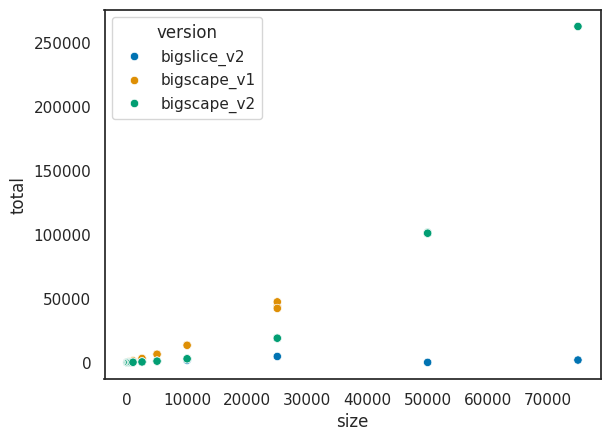

In [27]:

sns.scatterplot(totals, x="size", y="total", hue="version", palette=COLOR_MAP)

Text(0.5, 1.0, 'Runtime for sample sizes <= 5000')

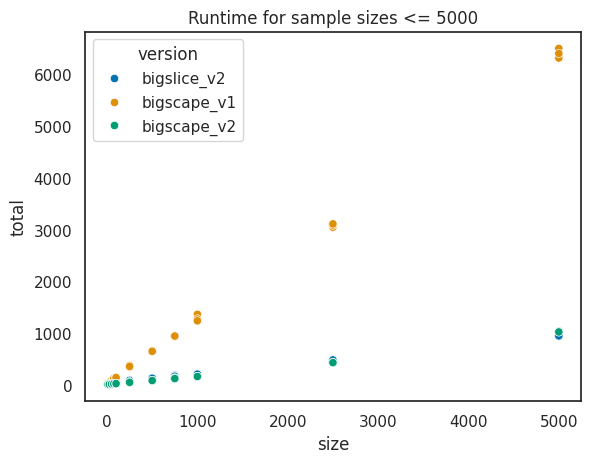

In [28]:
# points <= 10000
sns.scatterplot(totals[totals["size"] <= 5000], x="size", y="total", hue="version", palette=COLOR_MAP)
plt.title("Runtime for sample sizes <= 5000")

Text(0.5, 1.0, 'Proportional time spent on each step for v2')

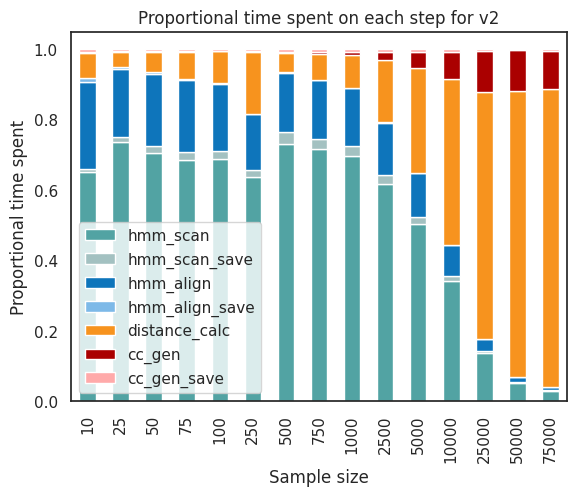

In [29]:
v2_prop_time_colors = [
    COLORS["bigscape_blue"],
    COLORS["bigscape_blue_pale"],
    COLORS["dark_blue"],
    COLORS["light_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"],
    COLORS["antismash_red_pale"]
]
prop_time_plot_v2 = bigscape_v2_avg_prop.plot(kind='bar', stacked=True, color=v2_prop_time_colors)
prop_time_plot_v2.set_xlabel("Sample size")
prop_time_plot_v2.set_ylabel("Proportional time spent")
plt.title("Proportional time spent on each step for v2")

Text(0.5, 1.0, 'Proportional time spent on each step for v1')

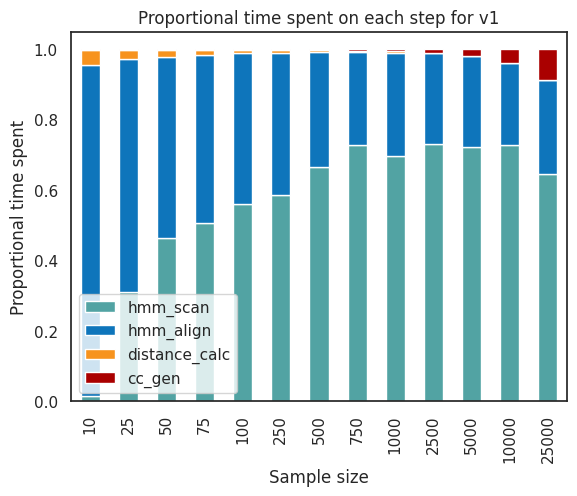

In [30]:
v1_prop_time_colors = [
    COLORS["bigscape_blue"],
    COLORS["dark_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"]
]
prop_time_plot_v1 = bigscape_v1_avg_prop.plot(kind='bar', stacked=True, color=v1_prop_time_colors)
prop_time_plot_v1.set_xlabel("Sample size")
prop_time_plot_v1.set_ylabel("Proportional time spent")
plt.title("Proportional time spent on each step for v1")

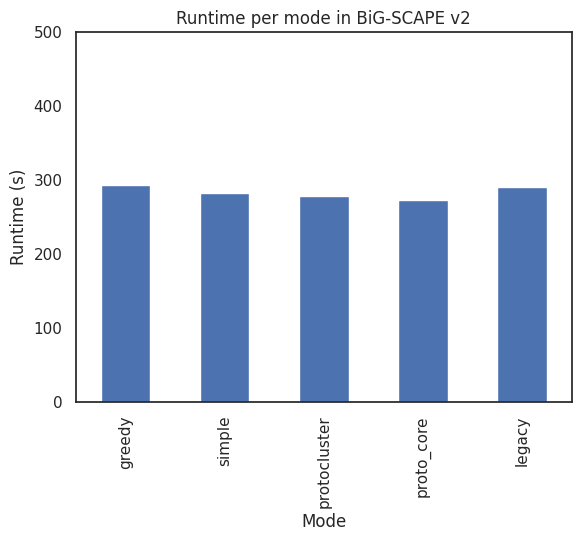

In [31]:
# bar chart for the modes
mode_totals.plot(kind='bar')
plt.title("Runtime per mode in BiG-SCAPE v2")
plt.xlabel("Mode")
plt.ylabel("Runtime (s)")
plt.ylim(0, 500)
plt.legend().remove()

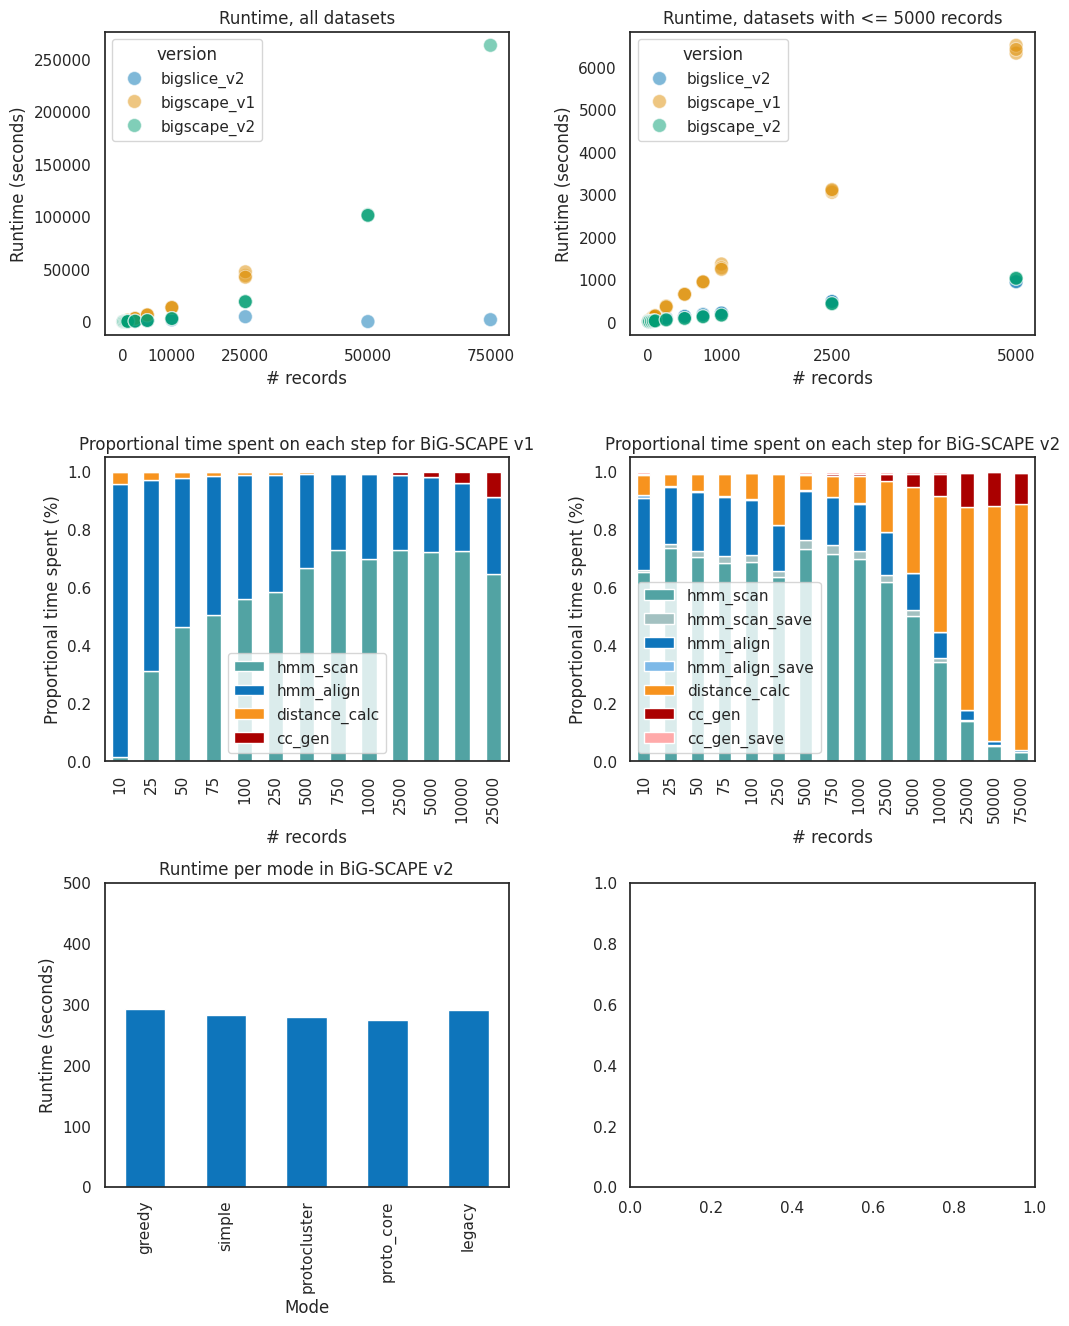

In [32]:
# collate into one image
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

### total runtimes

## a) total runtimes for all sample sizes
sns.scatterplot(
    ax=axes[0,0],
    data=totals,
    x="size",
    y="total",
    hue="version",
    palette=COLOR_MAP,
    s=100,
    alpha=0.5
)

# title
axes[0, 0].set_title("Runtime, all datasets")

# x axis options
axes[0, 0].set_xlabel("# records")
axes[0, 0].set_xticks([0, 10000, 25000, 50000, 75000])

# y axis options
axes[0, 0].set_ylabel("Runtime (seconds)")

## b) total runtimes for sample sizes <= 10000
# generate plot
sns.scatterplot(
    ax=axes[0,1],
    data=totals[totals["size"] <= 5000],
    x="size",
    y="total",
    hue="version",
    palette=COLOR_MAP,
    s=100,
    alpha=0.5
)

# title
axes[0, 1].set_title("Runtime, datasets with <= 5000 records")

# x axis options
axes[0, 1].set_xlabel("# records")
axes[0, 1].set_xticks([0, 1000, 2500, 5000])

# y axis options
axes[0, 1].set_ylabel("Runtime (seconds)")


### runtime proportional time spent

## c) proportional time spent on each step for v1
# generate plot
v1_prop_time_colors = [
    COLORS["bigscape_blue"],
    COLORS["dark_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"]
]
bigscape_v1_avg_prop.plot(ax=axes[1, 0], kind='bar', stacked=True, color=v1_prop_time_colors)

# title
axes[1, 0].set_title("Proportional time spent on each step for BiG-SCAPE v1")

# x axis options
axes[1, 0].set_xlabel("# records")

# y axis options
axes[1, 0].set_ylabel("Proportional time spent (%)")

## d) proportional time spent on each step for v2
# generate plot
v2_prop_time_colors = [
    COLORS["bigscape_blue"],
    COLORS["bigscape_blue_pale"],
    COLORS["dark_blue"],
    COLORS["light_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"],
    COLORS["antismash_red_pale"]
]
bigscape_v2_avg_prop.plot(ax=axes[1, 1], kind='bar', stacked=True, color=v2_prop_time_colors)

# title
axes[1, 1].set_title("Proportional time spent on each step for BiG-SCAPE v2")

# x axis options
axes[1, 1].set_xlabel("# records")

# y axis options
axes[1, 1].set_ylabel("Proportional time spent (%)")


### runtime per mode
mode_totals.plot(ax=axes[2, 0], kind='bar', color=COLORS["dark_blue"])
axes[2, 0].set_title("Runtime per mode in BiG-SCAPE v2")
axes[2, 0].set_xlabel("Mode")
axes[2, 0].set_ylabel("Runtime (seconds)")
axes[2, 0].set_ylim(0, 500)
axes[2, 0].legend().remove()

# increase margins
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)